# **Spam E-Mail Classification**

# Import Statements

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
from plotly import graph_objects as go
# from wordcloud import WordCloud
# from textwrap import wrap
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\0877\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# # Data collection

In [2]:
df = pd.read_csv(r'dataset\spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


## Analze data

In [3]:
df.shape

(5171, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5171.0,2585.000000,1492.883452,0.0,1292.5,2585.0,3877.5,5170.0
label_num,5171.0,0.289886,0.453753,0.0,0.0,0.0,1.0,1.0


In [8]:
df.columns

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')

In [9]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [10]:
# count the values on target column in numaric data
df['label_num'].value_counts()

label_num
0    3672
1    1499
Name: count, dtype: int64

## Analze:

* in here Unnamed: 0 is unneccssary column. 
* label_num contains value of label column. 
* labels:
    * 0 => ham
    * 1 => spam
* so we can drop Unnamed: 0 and label.

# # Data preprocessing

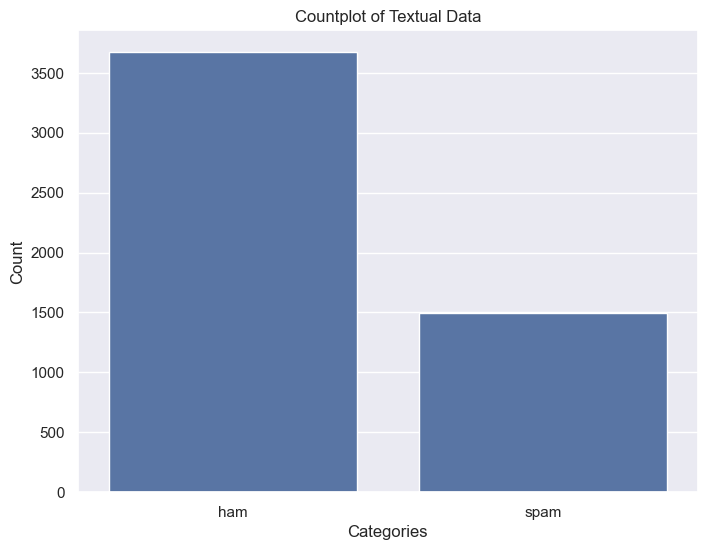

In [11]:
# 'label' column from the DataFrame 'df', visualizing the distribution of categories in the textual data.
sns.set(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.countplot(x=df['label'])
plt.title('Countplot of Textual Data')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

count     5171.00000
mean      1029.74531
std       1505.10317
min         10.00000
25%        238.00000
50%        529.00000
75%       1214.00000
max      31860.00000
Name: message_length, dtype: float64


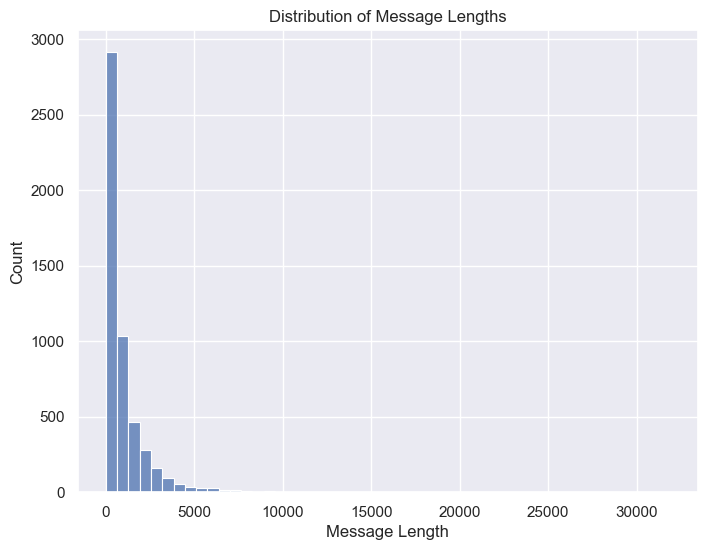

In [12]:
# length of messages
df["message_length"] = df["text"].apply(len)
print(df["message_length"].describe())

plt.figure(figsize=(8, 6))
sns.histplot(df["message_length"], bins=50)
plt.title("Distribution of Message Lengths")
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.show()

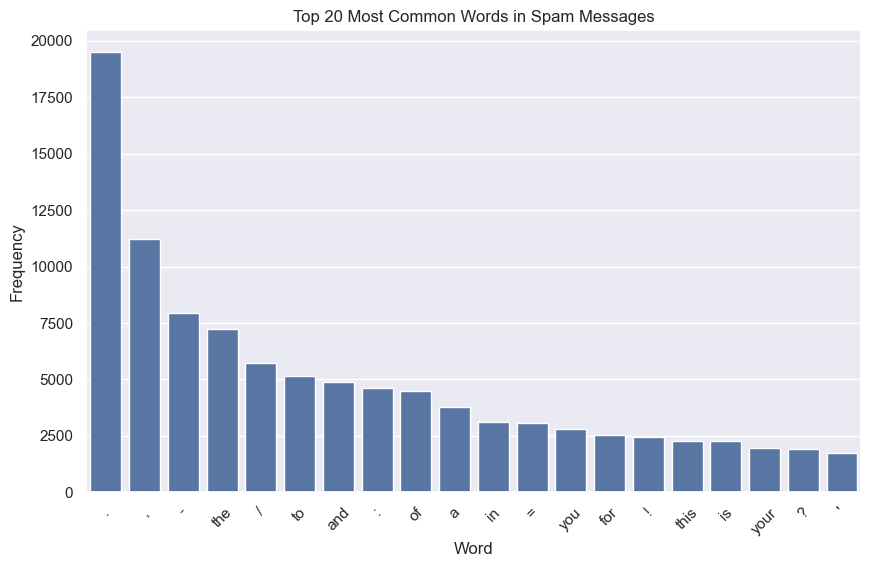

In [13]:
# Plot the top 20 most common words in spam messages

df['label'] = df['label'].map({"ham": 0, "spam": 1})
spam_data = df[df["label"] == 1]
spam_text = " ".join(spam_data["text"])
spam_words = spam_text.split()

# Create a word frequency distribution for spam messages
spam_word_freq = pd.Series(spam_words).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=spam_word_freq[:20].index, y=spam_word_freq[:20].values)
plt.title("Top 20 Most Common Words in Spam Messages")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

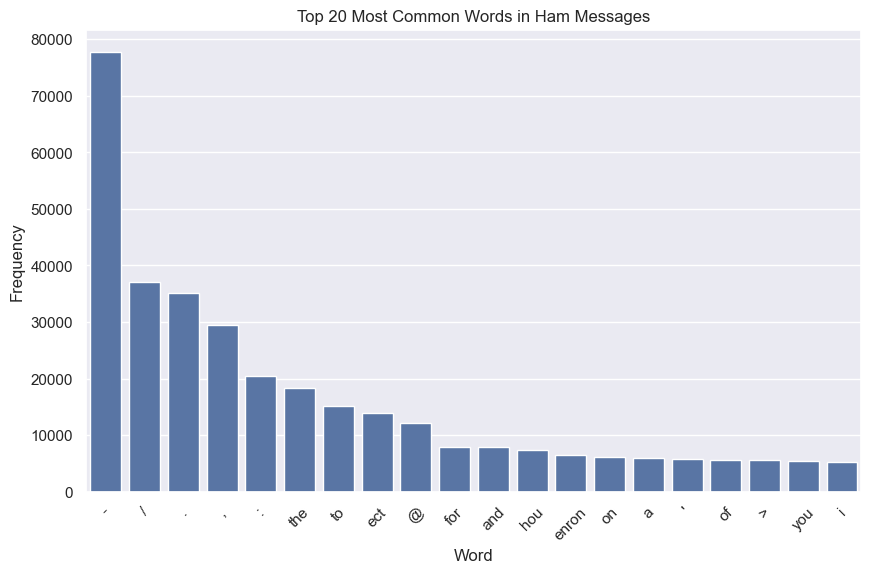

In [14]:
ham_data = df[df["label"] == 0]  # Filter rows with label 0, representing ham messages

if not ham_data.empty:
    ham_text = " ".join(ham_data["text"])
    ham_words = ham_text.split()

    # Create a word frequency distribution for ham messages
    ham_word_freq = pd.Series(ham_words).value_counts()

    # Plot the top 20 most common words in ham messages
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ham_word_freq[:20].index, y=ham_word_freq[:20].values)
    plt.title("Top 20 Most Common Words in Ham Messages")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No ham messages found.")

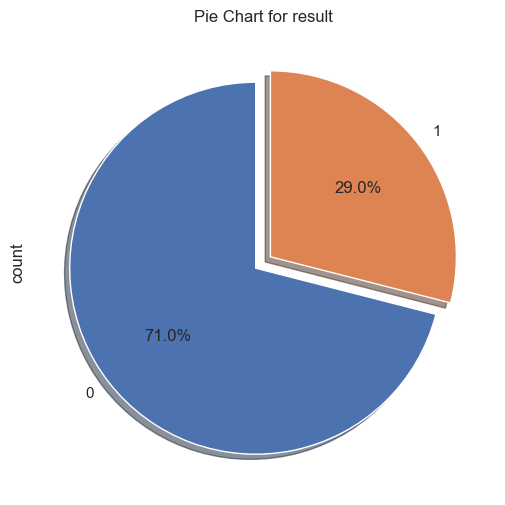

In [15]:
# Pie Chart for spam and ham percentage
df['label'].value_counts().plot.pie(explode=[0.05,0.05], autopct='%1.1f%%',  startangle=90,shadow=True, figsize=(6,8))
plt.title('Pie Chart for result')
plt.show()

# **Pre-Processing**

**This code selects only the 'label' and 'text' columns from the DataFrame 'df' and assigns the result back to 'df', effectively creating a new DataFrame with only these two columns**

In [16]:
df = df[['label','text']]

# # Data splitting

In [17]:
x = df.drop('label',axis=1)
y = df["label"]

In [18]:
""" The code "messages = x.copy()" creates a shallow copy of the list or dictionary object "x" 
and assigns it to the variable "messages." 
A shallow copy means that a new object is created, but the elements themselves are not duplicated. 
Instead, the new object references the same elements as the original object."""

messages = x.copy()
messages.reset_index(inplace=True)
messages.head()

,index,text
0,0,Subject: enron methanol ; meter # : 988291\nth...
1,1,"Subject: hpl nom for january 9 , 2001\n( see a..."
2,2,"Subject: neon retreat\nho ho ho , we ' re arou..."
3,3,"Subject: photoshop , windows , office . cheap ..."
4,4,Subject: re : indian springs\nthis deal is to ...


In [19]:
stop = set(stopwords.words('english'))

The given line of code appears to be a Python statement that imports the stopwords module from the nltk library, and then creates a set of English stopwords using the stopwords.words('english') function. A stopword is a common word (e.g., "the," "is," "and") that is often removed from text during natural language processing tasks, as it typically doesn't add significant meaning to the context.

In [20]:
crp = []
new = df['text'].str.split()
new = new.values.tolist()
crp = [word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)

for word in crp:
    if word in stop:
        dic[word]+=1

This above code counts the occurrences of stop words in the 'text' column of the DataFrame 'df' and stores the counts in a defaultdict named 'dic'.

In [21]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
clean_text = []
for i in range(0,len(messages)):
    review = re.sub('[^a-zA-Z]',' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    clean_text.append(review)

* Porter Stemmer: The code imports the PorterStemmer class from NLTK, which is a popular algorithm used for stemming words in the English language. The stemmer reduces words to their base or root form by removing common suffixes, such as -ing, -ed, -s, etc.

* Text Cleaning: The code aims to clean the text data stored in the messages variable. It removes any characters that are not letters (using the regular expression [^a-zA-Z]) and replaces them with spaces. This step ensures that only alphabetic characters remain in the text.

* Lowercasing: After removing non-alphabetic characters, the code converts all the remaining text to lowercase. This step is essential for making the text case-insensitive during further processing, such as tokenization and stemming.

* Stopwords Removal: The code utilizes the stopwords module from NLTK to remove common English stopwords from each tokenized review. Stopwords are words like "the," "a," "an," "and," etc., which do not carry significant meaning and are often removed to reduce noise in text data.

* Stemming and Tokenization: The code then tokenizes each review (splitting the text into individual words) and applies stemming using the Porter Stemmer. For each word in the tokenized review, it checks if the word is not a stopword and then applies stemming to reduce it to its root form.

In [22]:
df['clean_text'] = clean_text
df.head()

,label,text,clean_text
0,0,Subject: enron methanol ; meter # : 988291\nth...,subject enron methanol meter follow note gave ...
1,0,"Subject: hpl nom for january 9 , 2001\n( see a...",subject hpl nom januari see attach file hplnol...
2,0,"Subject: neon retreat\nho ho ho , we ' re arou...",subject neon retreat ho ho ho around wonder ti...
3,1,"Subject: photoshop , windows , office . cheap ...",subject photoshop window offic cheap main tren...
4,0,Subject: re : indian springs\nthis deal is to ...,subject indian spring deal book teco pvr reven...


In [23]:
x = df['clean_text']
y = df['label']

In [24]:
df['label'].value_counts()

label
0    3672
1    1499
Name: count, dtype: int64

In [25]:
from sklearn.feature_extraction.text import HashingVectorizer
hvectorizer = HashingVectorizer(n_features=10000,norm=None,alternate_sign=False,stop_words='english') 
x = hvectorizer.fit_transform(x).toarray()

The code snippet uses the HashingVectorizer from scikit-learn to convert text data into a fixed-size vector representation. It creates a vectorizer with 10,000 features, disables normalization, uses the original sign for the hash values, and removes English stop words during the vectorization process. The resulting x is a numpy array containing the transformed text data.

In [26]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
a,b = sm.fit_resample(x,y)

The next two lines perform oversampling using SMOTE (Synthetic Minority Over-sampling Technique) on the input data x and corresponding labels y, and store the resampled data and labels in variables a and b, respectively. SMOTE is a popular technique used to address class imbalance in machine learning datasets by generating synthetic samples for the minority class to balance the class distribution.

In [27]:
a.shape

(7344, 10000)

In [28]:
b.shape

(7344,)

In [29]:
b.value_counts()

label
0    3672
1    3672
Name: count, dtype: int64

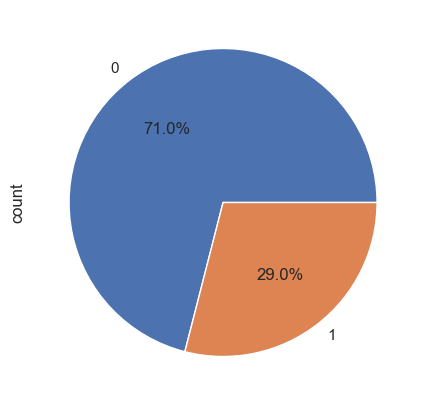

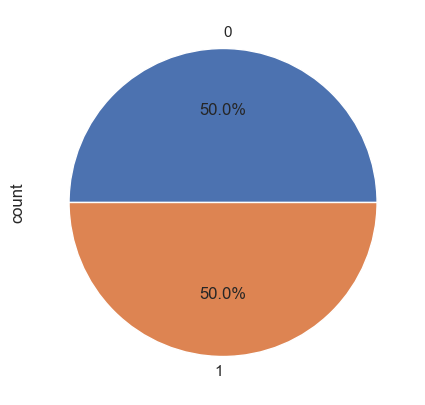

In [30]:
# plot the pie plot for the y before and after applying the smote technique
plt.figure(figsize=(10,5))
y.value_counts().plot.pie(autopct='%1.1f%%')
plt.show()
plt.figure(figsize=(10,5))
b.value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(a,b, test_size=0.3, random_state=42)

The above code snippet uses the train_test_split function from the sklearn.model_selection module to split the data a and b into training and testing sets. The split ratio is 70% for training and 30% for testing, and a random state of 42 is set to ensure reproducibility.

# # Algorithm implementation

In [32]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,classification_report,confusion_matrix
from tabulate import tabulate
import numpy as np
import time
import matplotlib.pyplot as plt
import joblib

## **RandomForestClassifier**

Random Forest Classifier Results:
+----------------------+---------+
| Metrics              |   Value |
+======================+=========+
| Accuracy             | 97.2323 |
+----------------------+---------+
| Precision            | 97.2719 |
+----------------------+---------+
| Recall               | 96.9981 |
+----------------------+---------+
| F1_score             | 97.1348 |
+----------------------+---------+
| ROC_AUC              | 99.6363 |
+----------------------+---------+
| Time Taken (seconds) | 18.8545 |
+----------------------+---------+

Classification report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1138
           1       0.97      0.97      0.97      1066

    accuracy                           0.97      2204
   macro avg       0.97      0.97      0.97      2204
weighted avg       0.97      0.97      0.97      2204



['Models/random_forest.joblib']

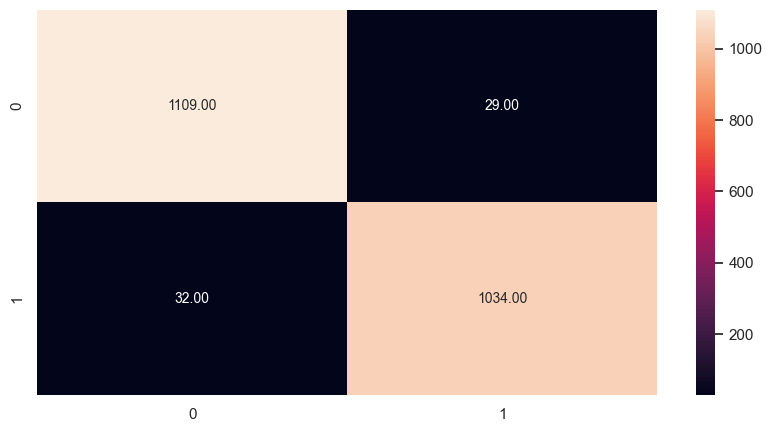

In [33]:
# Initialize Random Forest model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# model training
start_time = time.time()
rfc.fit(x_train, y_train)

# model testing
y_pred_rfc = rfc.predict(x_test)
end_time = time.time()

# Evaluation metrics
acc_rfc = accuracy_score(y_test, y_pred_rfc) * 100
pre_rfc = precision_score(y_test, y_pred_rfc) * 100
recall_rfc = recall_score(y_test, y_pred_rfc) * 100
f1_rfc = f1_score(y_test, y_pred_rfc) * 100
roc_auc_rfc = roc_auc_score(y_test, rfc.predict_proba(x_test)[:, 1]) * 100
report_rfc = classification_report(y_test, y_pred_rfc)

# Calculate time taken for training and prediction
execution_time_rfc = end_time - start_time

# Store results in a dictionary for Random Forest
results_rfc = {
    'Accuracy': acc_rfc,
    'Precision': pre_rfc,
    'Recall': recall_rfc,
    'F1_score': f1_rfc,
    'ROC_AUC': roc_auc_rfc,
    'Time Taken (seconds)': execution_time_rfc
}

# Display results in a table for Random Forest
print("Random Forest Classifier Results:")
print(tabulate(results_rfc.items(), headers=["Metrics", "Value"], tablefmt="grid"))
print('\nClassification report for Random Forest:\n', report_rfc)


# plot the confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test,y_pred_rfc),annot=True,fmt='0.2f',annot_kws={'size':10})

# Save the model to a file
joblib.dump(rfc, 'Models/random_forest.joblib')

## **Support Vector Classification**


Support Vector Classifier (SVC) Results:
+----------------------+----------+
| Metrics              |    Value |
+======================+==========+
| Accuracy             |  93.8748 |
+----------------------+----------+
| Precision            |  89.2165 |
+----------------------+----------+
| Recall               |  99.3433 |
+----------------------+----------+
| F1_score             |  94.008  |
+----------------------+----------+
| ROC_AUC              |  99.4308 |
+----------------------+----------+
| Time Taken (seconds) | 114.838  |
+----------------------+----------+

Classification report for SVC:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      1138
           1       0.89      0.99      0.94      1066

    accuracy                           0.94      2204
   macro avg       0.94      0.94      0.94      2204
weighted avg       0.94      0.94      0.94      2204



['Models/svc.joblib']

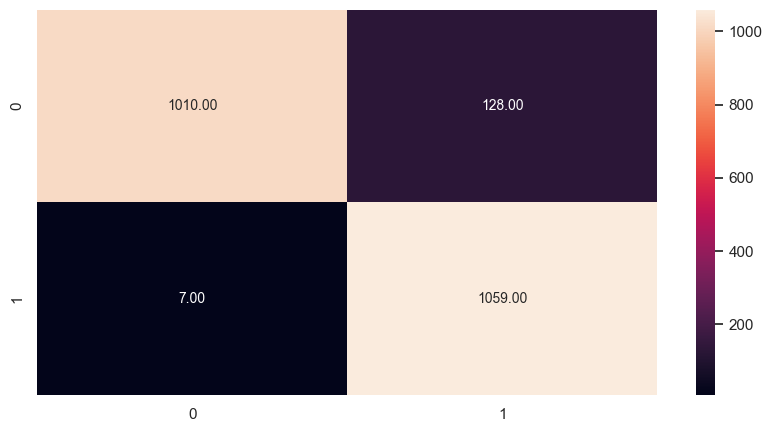

In [34]:
# Initialize Support Vector Classifier
from sklearn.svm import SVC
svc = SVC(random_state=42)

# Model training
start_time_svc = time.time()
svc.fit(x_train, y_train)

# Model testing
y_pred_svc = svc.predict(x_test)
end_time_svc = time.time()

# Evaluation metrics
acc_svc1 = accuracy_score(y_test, y_pred_svc) * 100
pre_svc1 = precision_score(y_test, y_pred_svc) * 100
recall_svc1 = recall_score(y_test, y_pred_svc) * 100
f1_svc1 = f1_score(y_test, y_pred_svc) * 100
roc_auc_svc = roc_auc_score(y_test, svc.decision_function(x_test)) * 100
report_svc = classification_report(y_test, y_pred_svc)

# Calculate time taken for training and prediction for SVC
execution_time_svc = end_time_svc - start_time_svc

# Store results in a dictionary for SVC
results_svc = {
    'Accuracy': acc_svc1,
    'Precision': pre_svc1,
    'Recall': recall_svc1,
    'F1_score': f1_svc1,
    'ROC_AUC': roc_auc_svc,
    'Time Taken (seconds)': execution_time_svc
}

# Display results in a table for SVC
print("\nSupport Vector Classifier (SVC) Results:")
print(tabulate(results_svc.items(), headers=["Metrics", "Value"], tablefmt="grid"))
print('\nClassification report for SVC:\n', report_svc)

# plot the confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test,y_pred_svc),annot=True,fmt='0.2f',annot_kws={'size':10})

# Save the model to a file
joblib.dump(svc, 'Models/svc.joblib')

## **Multinomial Naive Bayes**

Naive Bayes Classifier Results:
+----------------------+-----------+
| Metrics              |     Value |
+======================+===========+
| Accuracy             | 95.4174   |
+----------------------+-----------+
| Precision            | 94.7173   |
+----------------------+-----------+
| Recall               | 95.8724   |
+----------------------+-----------+
| F1_score             | 95.2914   |
+----------------------+-----------+
| ROC_AUC              | 98.2823   |
+----------------------+-----------+
| Time Taken (seconds) |  0.218992 |
+----------------------+-----------+

Classification report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1138
           1       0.95      0.96      0.95      1066

    accuracy                           0.95      2204
   macro avg       0.95      0.95      0.95      2204
weighted avg       0.95      0.95      0.95      2204



['Models/MultinomialNB.joblib']

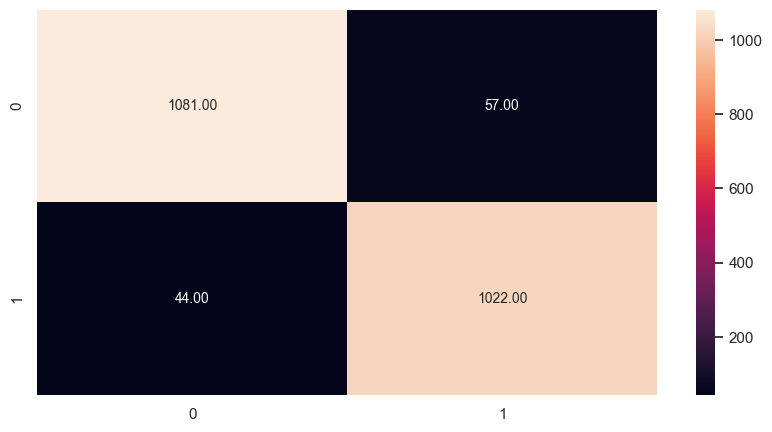

In [35]:
# Initialize and train the Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Model training
start_time = time.time()
nb.fit(x_train, y_train)

# Model testing
y_pred_nb = nb.predict(x_test)
end_time = time.time()

# Evaluation metrics
acc_nb = accuracy_score(y_test, y_pred_nb) * 100
pre_nb = precision_score(y_test, y_pred_nb) * 100
recall_nb = recall_score(y_test, y_pred_nb) * 100
f1_nb = f1_score(y_test, y_pred_nb) * 100
roc_auc_nb = roc_auc_score(y_test, nb.predict_proba(x_test)[:, 1]) * 100
report_nb = classification_report(y_test, y_pred_nb)

# Calculate time taken for training and prediction
execution_time_nb = end_time - start_time

# Store results in a dictionary for Naive Bayes
results_nb = {
    'Accuracy': acc_nb,
    'Precision': pre_nb,
    'Recall': recall_nb,
    'F1_score': f1_nb,
    'ROC_AUC': roc_auc_nb,
    'Time Taken (seconds)': execution_time_nb
}

# Display results in a table for Naive Bayes
print("Naive Bayes Classifier Results:")
print(tabulate(results_nb.items(), headers=["Metrics", "Value"], tablefmt="grid"))
print('\nClassification report for Naive Bayes:\n', report_nb)

# plot the confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test,y_pred_nb),annot=True,fmt='0.2f',annot_kws={'size':10})

# Save the model to a file
joblib.dump(nb, 'Models/MultinomialNB.joblib')

## **CatBoostClassifier**

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


Learning rate set to 0.020726
0:	learn: 0.6716038	total: 403ms	remaining: 6m 42s
1:	learn: 0.6516375	total: 571ms	remaining: 4m 44s
2:	learn: 0.6346559	total: 750ms	remaining: 4m 9s
3:	learn: 0.6181218	total: 879ms	remaining: 3m 38s
4:	learn: 0.6008756	total: 1.13s	remaining: 3m 44s
5:	learn: 0.5861966	total: 1.28s	remaining: 3m 31s
6:	learn: 0.5718795	total: 1.41s	remaining: 3m 19s
7:	learn: 0.5571358	total: 1.55s	remaining: 3m 11s
8:	learn: 0.5434965	total: 1.68s	remaining: 3m 5s
9:	learn: 0.5310329	total: 1.82s	remaining: 3m
10:	learn: 0.5195426	total: 2s	remaining: 3m
11:	learn: 0.5085402	total: 2.16s	remaining: 2m 58s
12:	learn: 0.4967862	total: 2.33s	remaining: 2m 56s
13:	learn: 0.4861297	total: 2.5s	remaining: 2m 56s
14:	learn: 0.4752645	total: 2.66s	remaining: 2m 54s
15:	learn: 0.4651601	total: 2.8s	remaining: 2m 52s
16:	learn: 0.4560174	total: 2.95s	remaining: 2m 50s
17:	learn: 0.4472367	total: 3.12s	remaining: 2m 50s
18:	learn: 0.4369386	total: 3.27s	remaining: 2m 48s
19:	lea

['Models/catboost.joblib']

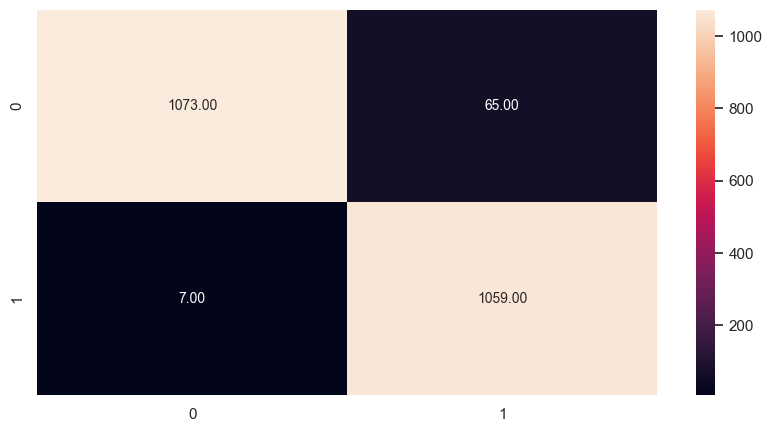

In [36]:
# Initialize and train the CatBoost model
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier()

# Model training
start_time = time.time()
catboost_model.fit(x_train, y_train)

# Model testing
y_pred_catboost = catboost_model.predict(x_test)
end_time = time.time()

# Evaluation metrics
acc_catboost = accuracy_score(y_test, y_pred_catboost) * 100
pre_catboost = precision_score(y_test, y_pred_catboost) * 100
recall_catboost = recall_score(y_test, y_pred_catboost) * 100
f1_catboost = f1_score(y_test, y_pred_catboost) * 100
roc_auc_catboost = roc_auc_score(y_test, catboost_model.predict_proba(x_test)[:, 1]) * 100
report_catboost = classification_report(y_test, y_pred_catboost)

# Calculate time taken for training and prediction
execution_time_catboost = end_time - start_time

# Store results in a dictionary for CatBoost
results_catboost = {
    'Accuracy': acc_catboost,
    'Precision': pre_catboost,
    'Recall': recall_catboost,
    'F1_score': f1_catboost,
    'ROC_AUC': roc_auc_catboost,
    'Time Taken (seconds)': execution_time_catboost
}

# Display results in a table for CatBoost
print("CatBoost Classifier Results:")
print(tabulate(results_catboost.items(), headers=["Metrics", "Value"], tablefmt="grid"))
print('\nClassification report for CatBoost:\n', report_catboost)

# plot the confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test,y_pred_catboost),annot=True,fmt='0.2f',annot_kws={'size':10})

# Save the model to a file
joblib.dump(catboost_model, 'Models/catboost.joblib')

# # Model comparision

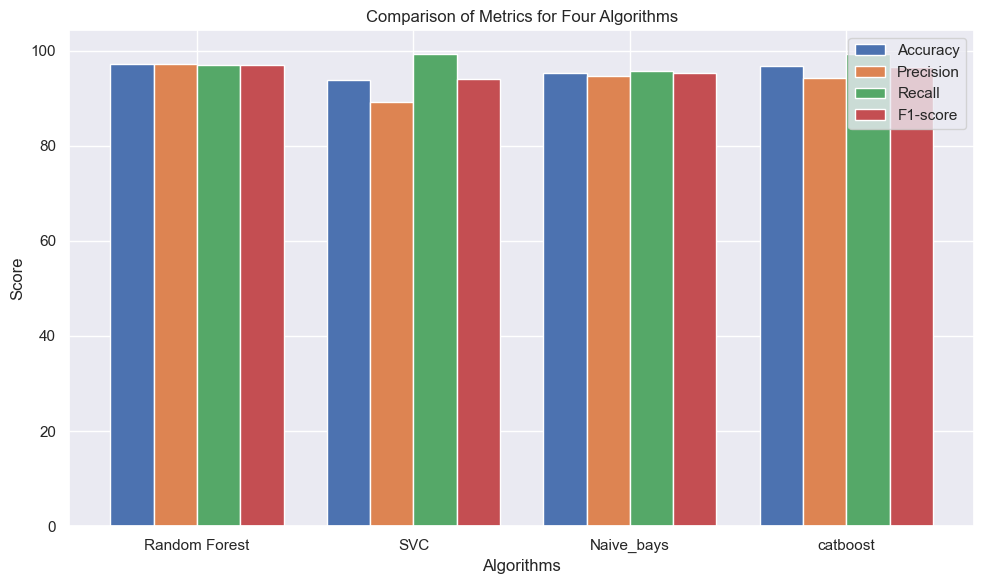

In [37]:
# Lists to store the metrics for each algorithm
algorithms = ['Random Forest','SVC','Naive_bays','catboost']
accuracies = [acc_rfc, acc_svc1,acc_nb,acc_catboost]
precisions = [pre_rfc,pre_svc1,pre_nb,pre_catboost]
recalls = [recall_rfc,recall_svc1,recall_nb,recall_catboost]
f1_scores = [f1_rfc,f1_svc1,f1_nb,f1_catboost]

x = np.arange(len(algorithms))
bar_width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5 * bar_width, accuracies, bar_width, label='Accuracy', align='center')
ax.bar(x - 0.5 * bar_width, precisions, bar_width, label='Precision', align='center')
ax.bar(x + 0.5 * bar_width, recalls, bar_width, label='Recall', align='center')
ax.bar(x + 1.5 * bar_width, f1_scores, bar_width, label='F1-score', align='center')
ax.set_xlabel('Algorithms')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics for Four Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()
plt.tight_layout()
plt.show()

# **Prediction**

In [38]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(n_features=10000, norm=None, alternate_sign=False, stop_words='english')

import joblib
model = joblib.load(r"Models\random_forest.joblib")


def preprocess_text(input):
    input = re.sub('[^a-zA-Z]', ' ', input)
    input = input.lower()
    input = input.split()
    input = [ps.stem(word) for word in input if not word in stopwords.words('english')]
    input = ' '.join(input)
    return input


def prediction_func(input):
    preprocessed_text = preprocess_text(input)
    vectorized_text = vectorizer.transform([preprocessed_text]).toarray()
    # vectorized_input = hvectorizer.fit_transform(preprocessed_text).toarray()
    prediction = model.predict(vectorized_text)

    if prediction == 0:
        print('This is a Ham Mail')
    else:
        print('This is a Spam Mail')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\0877\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Example for Ham mail
prediction_func('''Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !
i know that this time of year is extremely hectic , and that it ' s tough to think about anything past the holidays , but life does go on past the week of december 25 through january 1 , and that ' s what i ' d like you to think about for a minute .
on the calender that i handed out at the beginning of the fall semester , the retreat was scheduled for the weekend of january 5 - 6 . but because of a youth ministers conference that brad and dustin are connected with that week , we ' re going to change the date to the following weekend , january 12 - 13 . now comes the part you need to think about .
i think we all agree that it ' s important for us to get together and have some time to recharge our batteries before we get to far into the spring semester , but it can be a lot of trouble and difficult for us to get away without kids , etc . so , brad came up with a potential alternative for how we can get together on that weekend , and then you can let me know which you prefer .
the first option would be to have a retreat similar to what we ' ve done the past several years . this year we could go to the heartland country inn ( www . . com ) outside of brenham . it ' s a nice place , where we ' d have a 13 - bedroom and a 5 - bedroom house side by side . it ' s in the country , real relaxing , but also close to brenham and only about one hour and 15 minutes from here . we can golf , shop in the antique and craft stores in brenham , eat dinner together at the ranch , and spend time with each other . we ' d meet on saturday , and then return on sunday morning , just like what we ' ve done in the past .
the second option would be to stay here in houston , have dinner together at a nice restaurant , and then have dessert and a time for visiting and recharging at one of our homes on that saturday evening . this might be easier , but the trade off would be that we wouldn ' t have as much time together . i ' ll let you decide .
email me back with what would be your preference , and of course if you ' re available on that weekend . the democratic process will prevail - - majority vote will rule ! let me hear from you as soon as possible , preferably by the end of the weekend . and if the vote doesn ' t go your way , no complaining allowed ( like i tend to do ! )
have a great weekend , great golf , great fishing , great shopping , or whatever makes you happy !
bobby''')

This is a Ham Mail


In [40]:
# Example for Spam mail
prediction_func('''Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin
''')

This is a Spam Mail
